In [2]:
# Enable autoreload extension
%load_ext autoreload
# Automatically reload all modules (except built-ins) before executing code
%autoreload 2

import sys
import os
os.chdir("/home/gdallagl/myworkdir/ESMSec")
print(f"Working directory successfully changed to: {os.getcwd()}")

import utils.my_functions as mf
import utils.embeddings_functions as my_embs

import matplotlib.pyplot as plt
import ast
from scipy.spatial.distance import pdist, squareform

import torch
import random
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import seaborn as sns
import scanpy as sc


big_palette = [
    # "#000000",  # remove the black, as often, we have black colored annotation
    "#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72", "#6A3A4C",
    "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059", "#FFFF00",
    "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
    "#5A0007", "#809693", "#FEFFE6", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
    "#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
    "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
    "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
    "#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
    "#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
    "#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
    "#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",
    "#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",
    "#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
]

print(torch.__version__)

Working directory successfully changed to: /home/gdallagl/myworkdir/ESMSec
2.5.0+cu121


In [3]:
# Configuration / hyperparameters
config = {
    "SEED": 42,             # Random seed

    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu", # Device to use (cuda or cpu)

    "TYPE_EMB_FOR_CLASSIFICATION": "cls", #"concat(agg_mean, agg_max)", #"contextualized_embs", #"concat(agg_mean, agg_max)",cls, stacked_linearized_all
    "PRETRAIN_ESM_CHECKPOINT_NAME": 
        #"facebook/esm2_t48_15B_UR50D", 
        "facebook/esm2_t36_3B_UR50D",
        # #"facebook/esm2_t33_650M_UR50D", 
        # #"facebook/esm2_t12_35M_UR50D", 
        # #"facebook/esm2_t6_8M_UR50D", 

    "UNIPROT_PATH": "/home/gdallagl/myworkdir/ESMSec/data/UniProt/human_proteome.tsv",
    "UNIPROT_CELLULAR_LOCATION_FORMATTED_PATH": "/home/gdallagl/myworkdir/ESMSec/data/UniProt/uniprotkb_reviewed_cellular_locations_formatted.csv"
}

# This 2 files are create by 00_make... script
config["PRECOMPUTED_EMBS_PATH"] = os.path.join(
    f"/home/gdallagl/myworkdir/ESMSec/data/UniProt/precomputed_embs",
    f"entire_reviewed_uniprot_{config['PRETRAIN_ESM_CHECKPOINT_NAME'].replace('/', '-')}_"
    f"{config['TYPE_EMB_FOR_CLASSIFICATION']}.safetensors"
)
config["PRECOMPUTED_EMBS_PATH_PROTEIN_NAMES"] = config["PRECOMPUTED_EMBS_PATH"].replace('.safetensors', '_names.json')
config["PRECOMPUTED_EMBS_PATH_ADATA"] = config["PRECOMPUTED_EMBS_PATH"].replace('.safetensors', '.h5ad')


# Initializations
random.seed(config["SEED"])
np.random.seed(config["SEED"])
torch.manual_seed(config["SEED"])
torch.backends.cudnn.benchmark = True 

# Load Anndata

In [27]:
adata = sc.read_h5ad(config["PRECOMPUTED_EMBS_PATH_ADATA"])
adata

AnnData object with n_obs × n_vars = 20405 × 1000
    obs: 'protein', 'gene', 'Reviewed', 'Gene Names', 'Organism', 'Length', 'Protein names', 'sequence', 'truncated_sequence'
    uns: 'X_umap_all', 'X_umap_pca', 'neighbors_all', 'neighbors_pca', 'pca', 'vocabulary'
    obsm: 'X_all', 'X_pca', 'X_umap_all', 'X_umap_pca'
    layers: 'attention_mask'
    obsp: 'neighbors_all_connectivities', 'neighbors_all_distances', 'neighbors_pca_connectivities', 'neighbors_pca_distances'

# Cluster

## First loose clustering

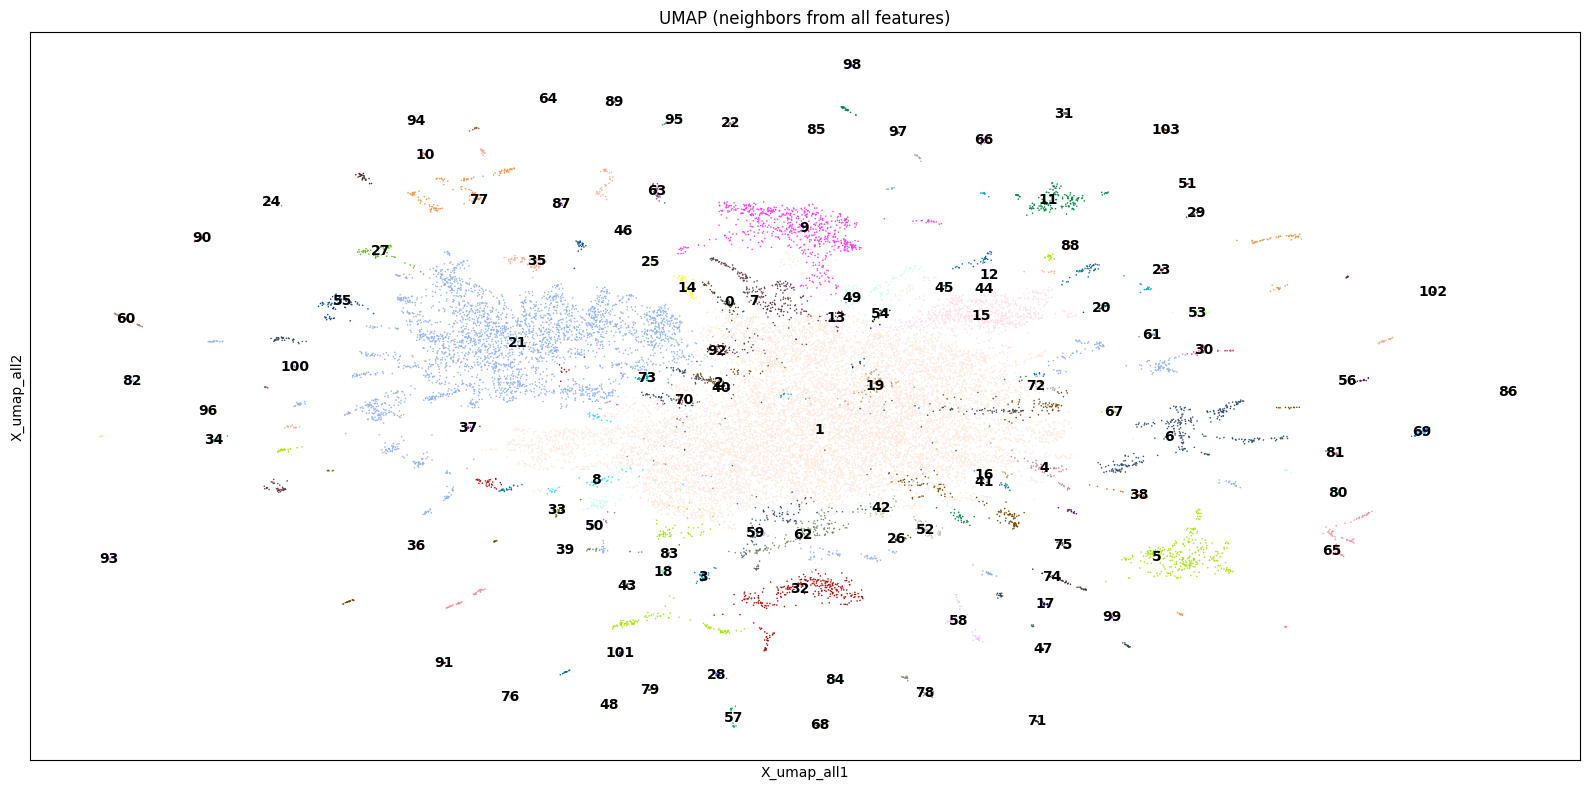

In [5]:
FEATURES = "all"
# clyster key ot use inthe analays
CLUSTER_KEY = f"leiden_{FEATURES}_initial_loose"
    # f"leiden_{FEATURES}_initial_loose", 
    # f"leiden_{FEATURES}_iterative"
RESOLUTION = 0.21

sc.tl.leiden(adata, resolution=RESOLUTION, neighbors_key=f"neighbors_{FEATURES}", key_added=f"leiden_{FEATURES}_iterative", flavor="igraph", n_iterations=2)

# save this isnitla
adata.obs[f"leiden_{FEATURES}_initial_loose"] = adata.obs[f"leiden_{FEATURES}_iterative"]

fig, axes = my_embs.plot_embeddings(
    adata,
    basis=[f"X_umap_{FEATURES}"],
    color=[f"leiden_{FEATURES}_initial_loose"],
    title=["UMAP (neighbors from all features)"],
    size=[5],
    palette=[big_palette],
    ncols=1,  # 2 columns, 2 rows
    figsize=(16, 8), 
    legend_loc=['on data'],
)
plt.show()

## Iterative clustering

Interation 1


Interation 2


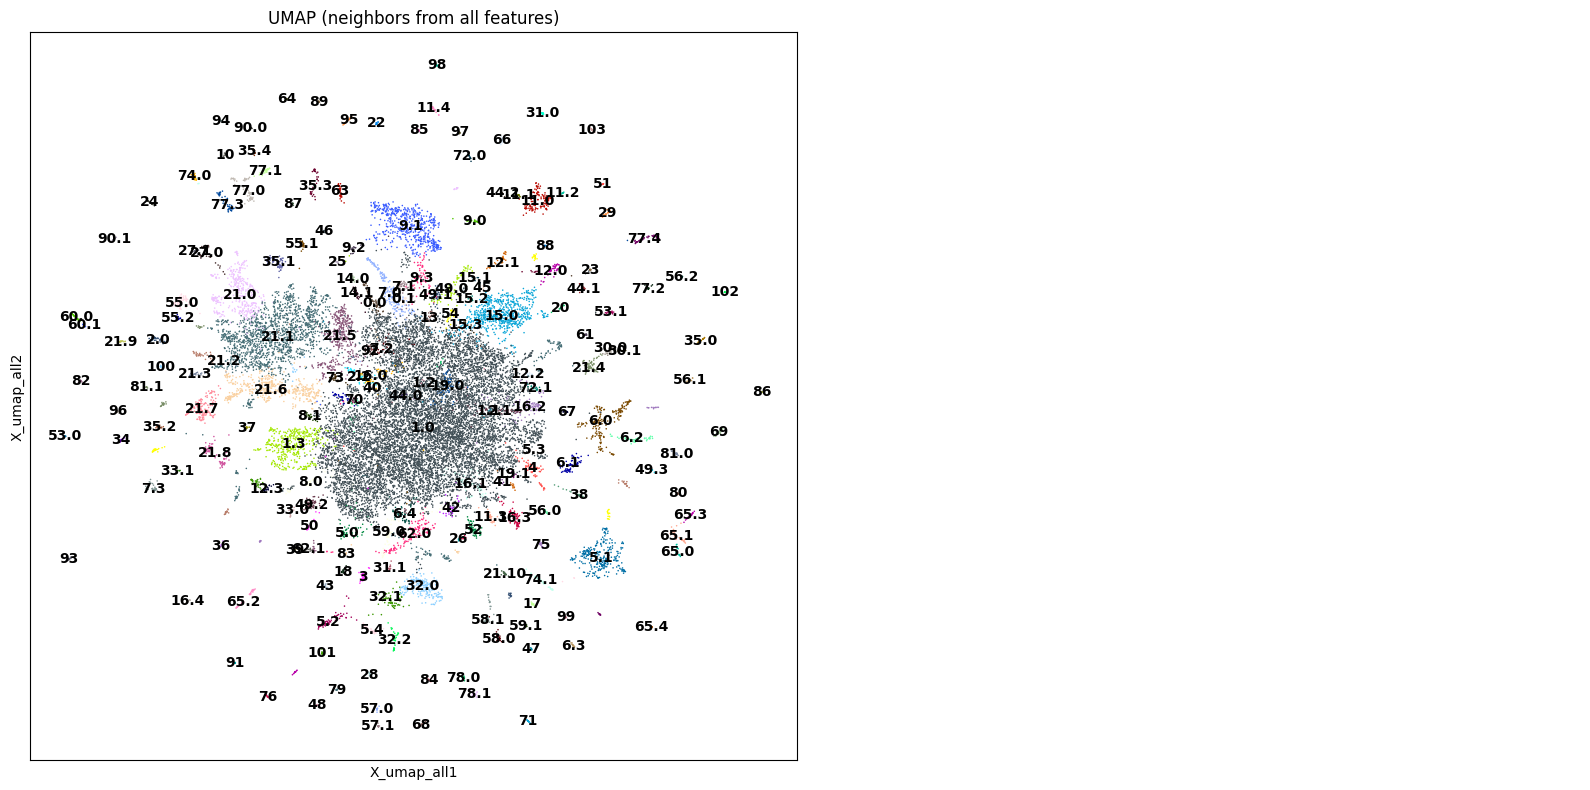

189


In [6]:

clusters_to_split = adata.obs[f"leiden_{FEATURES}_iterative"].unique().tolist()

n_iter = 1
while len(clusters_to_split) != 0:

    print(f"Interation {n_iter}")

    new_clusters_to_split = []

    for c in clusters_to_split:

        # --- Subset ---
        adata_sub = adata[adata.obs[f"leiden_{FEATURES}_iterative"] == str(c)].copy()

        # --- Check if splitting produced new subclusters ---
        if adata_sub.n_obs <= 10:
            #print(f"Skipping cluster {c} (too few cells: {adata_sub.n_obs})")
            continue

        # --- Neighbors ---
        #print(f"Calculating neighbors for cluster {c}...")
        sc.pp.neighbors(
            adata_sub,
            use_rep=f"X_{FEATURES}",
            n_neighbors=10,
            n_pcs=None,
            key_added=f"neighbors_{FEATURES}_new"
        )

        # --- Leiden clustering ---
        #print("Running Leiden...")
        sc.tl.leiden(
            adata_sub,
            resolution=0.1,
            neighbors_key=f"neighbors_{FEATURES}_new",
            key_added=f"leiden_{FEATURES}_iterative_new",
            flavor="igraph",
            n_iterations=2
        )

        # --- Check if splitting produced new subclusters ---
        if len(adata_sub.obs[f"leiden_{FEATURES}_iterative_new"].unique()) == 1:
            continue  # no further splitting needed

        # --- Combine old + new cluster labels ---
        combined_label = (
            adata_sub.obs[f"leiden_{FEATURES}_iterative"].astype(str)
            + "."
            + adata_sub.obs[f"leiden_{FEATURES}_iterative_new"].astype(str)
        )

        # Update the original AnnData (matching indices)
        adata.obs[f"leiden_{FEATURES}_iterative"] = adata.obs[f"leiden_{FEATURES}_iterative"].astype(str) # need to not be categorical
        adata.obs.loc[adata_sub.obs_names, f"leiden_{FEATURES}_iterative"] = combined_label

        # --- Add to further splitting list ---
        new_clusters_to_split.extend(adata_sub.obs[f"leiden_{FEATURES}_iterative_new"].unique().tolist())

    clusters_to_split = new_clusters_to_split
    #print(f"Next iteration clusters to split: {clusters_to_split}")
    n_iter +=1



fig, axes = my_embs.plot_embeddings(
    adata,
    basis=[f"X_umap_{FEATURES}"],
    color=[f"leiden_{FEATURES}_iterative"],
    title=["UMAP (neighbors from all features)"],
    size=[5],
    palette=[big_palette],
    ncols=2,  # 2 columns, 2 rows
    figsize=(16, 8), 
    legend_loc=['on data'],
)
plt.show()
print(adata.obs[f"leiden_{FEATURES}_iterative"].nunique())

In [7]:
# # SEE SPECIFIC CLUSTER SUBCLUSTERING

# # --- Subset ---
# adata_sub = adata[adata.obs[KEY_OBS_CLUSTERS] == "1"].copy()

# # --- Neighbors ---
# #print(f"Calculating neighbors for cluster {c}...")
# sc.pp.neighbors(
#     adata_sub,
#     use_rep=f"X_{FEATURES}",
#     n_neighbors=10,
#     n_pcs=None,
#     key_added=f"neighbors_{FEATURES}_new"
# )

# sc.tl.umap(adata_sub, random_state=42, neighbors_key=f"neighbors_{FEATURES}_new", key_added="X_umap_new") # each time overweites X_umap


# # --- Leiden clustering ---
# #print("Running Leiden...")
# sc.tl.leiden(
#     adata_sub,
#     resolution=0.1,
#     neighbors_key=f"neighbors_{FEATURES}_new",
#     key_added=f"{KEY_OBS_CLUSTERS}_new",
#     flavor="igraph",
#     n_iterations=2
# )

# fig, axes = my_embs.plot_embeddings(
#     adata_sub,
#     basis=[f"X_umap_new", f"X_umap_pca"],
#     color=[f"{KEY_OBS_CLUSTERS}_new"],
#     title=["X_umap_new"],
#     size=[20],
#     #palette=[["#0000A6"]],
#     ncols=2,  # 2 columns, 2 rows
#     figsize=(12, 5), 
#     #groups=[CLUSTER],
# )
# plt.show()

# # Investiagte single cluster
# CLUSTER = "2"

# fig, axes = my_embs.plot_embeddings(
#     adata_sub,
#     basis=[f"X_umap_pca"],
#     color=[f"{KEY_OBS_CLUSTERS}_new"],
#     #title=["Secreted Status"],
#     size=[20],
#     palette=[["#0000A6"]],
#     ncols=1,  # 2 columns, 2 rows
#     figsize=(8, 5), 
#     groups=[CLUSTER],
# )
# plt.show()

# uniprot_ids = adata_sub.obs[adata_sub.obs[f"{KEY_OBS_CLUSTERS}_new"] == CLUSTER].index

# print(f"{'UniProt ID':<12} {'Gene':<12} {'Function'}")
# print("="*100)
# for uid in uniprot_ids[:10]:
#     gene, func = mf.get_uniprot_info(uid)
#     print(f"{uid:<12} {gene:<12} {func}")
# print("...")

# Choose clusteer to investigate

In [8]:
# Investiagte single cluster
CLUSTER = "4"

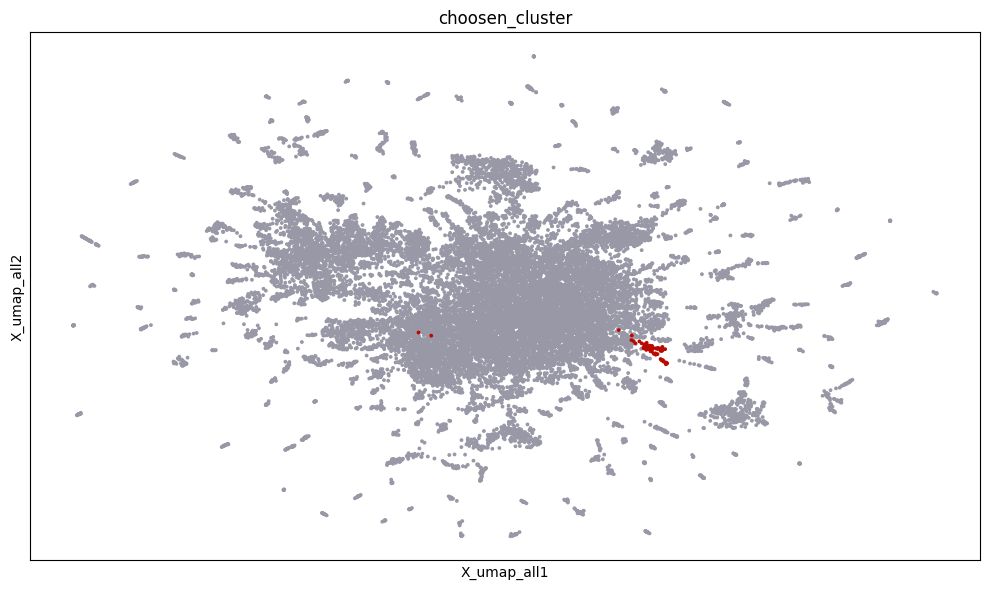

['A6NDE4', 'O00425', 'O75494', 'P09651', 'P0DJD3', 'P0DJD4', 'P11940', 'P22626', 'P31483', 'P38159', 'P51991', 'P52298', 'P57052', 'P84103', 'P98179', 'Q01085', 'Q01130', 'Q07955', 'Q08170', 'Q13151', 'Q13242', 'Q13243', 'Q13247', 'Q13310', 'Q14011', 'Q15415', 'Q15427', 'Q16629', 'Q4VXU2', 'Q76FK4', 'Q8WXF0', 'Q96DH6', 'Q96EP5', 'Q96PK6', 'Q96T58', 'Q9BQ04', 'Q9BRL6', 'Q9BWF3', 'Q9H361', 'Q9NW13', 'Q9NX07', 'Q9NZI8', 'Q9UNP9', 'Q9Y388', 'Q9Y3B4', 'Q9Y4C8', 'Q9Y580', 'Q9Y6M1', 'A6NEQ0', 'O43347', 'P0C7P1', 'Q96DU9', 'Q9NTZ6', 'O75526', 'P0CB38', 'Q32P51', 'Q5JQF8', 'Q8IXT5', 'Q96E39', 'A0A2R8Y4L2', 'Q8N7X1']
UniProt ID   Gene         Function
A6NDE4       RBMY1B       RNA-binding protein which may be involved in spermatogenesis. Required for sperm development, possibly by participating in pre-mRNA splicing in the...
O00425       IGF2BP3      RNA-binding factor that may recruit target transcripts to cytoplasmic protein-RNA complexes (mRNPs). This transcript 'caging' into mRNPs allows mRN

In [9]:
cluster_proteins = adata.obs[adata.obs[CLUSTER_KEY] == CLUSTER].protein.to_list()
adata.obs[f"choosen_cluster"] = [1 if p in cluster_proteins else None for p in adata.obs.protein]
adata.obs[f"choosen_cluster"] = pd.Categorical(
    adata.obs[f"choosen_cluster"],
    categories=[1],  # 0 plotted first (bottom), 1 on top
    ordered=True
)

fig, axes = my_embs.plot_embeddings(
    adata,
    basis=[f"X_umap_{FEATURES}"],
    color=["choosen_cluster"],
    #title=["Secreted Status"],
    size=[30],
    palette=[["#BA0900"]],
    ncols=1,  # 2 columns, 2 rows
    na_color= "#9898A7",
    figsize=(10, 6), 
    legend_loc="none",
)
plt.show()

uniprot_ids = adata.obs[adata.obs[CLUSTER_KEY] == CLUSTER].protein
print(uniprot_ids.to_list())

print(f"{'UniProt ID':<12} {'Gene':<12} {'Function'}")
print("="*100)
for uid in uniprot_ids[:10]:
    gene, func = mf.get_uniprot_info(uid)
    print(f"{uid:<12} {gene:<12} {func}")
print("...")

### Optional: create FASTA file

In [10]:
adata_fasta = adata[adata.obs[CLUSTER_KEY] == CLUSTER].copy()

print(adata_fasta)

with open(f"/home/gdallagl/myworkdir/ESMSec/data/_tmp/protein_classification_cluster_{CLUSTER}.fasta", "w") as f:
    for i, row in adata_fasta.obs.iterrows():
        f.write(f">{row.protein}\n")
        # Split long sequences every 60 chars (FASTA style)
        for i in range(0, len(row.truncated_sequence), 60):
            f.write(row.truncated_sequence[i:i+60] + "\n")

            #break

AnnData object with n_obs × n_vars = 61 × 1000
    obs: 'protein', 'gene', 'Reviewed', 'Gene Names', 'Organism', 'Length', 'Protein names', 'sequence', 'truncated_sequence', 'leiden_all_iterative', 'leiden_all_initial_loose', 'choosen_cluster'
    uns: 'X_umap_all', 'X_umap_pca', 'neighbors_all', 'neighbors_pca', 'pca', 'vocabulary', 'leiden_all_iterative', 'leiden_all_initial_loose_colors', 'leiden_all_iterative_colors', 'choosen_cluster_colors'
    obsm: 'X_all', 'X_pca', 'X_umap_all', 'X_umap_pca'
    layers: 'attention_mask'
    obsp: 'neighbors_all_connectivities', 'neighbors_all_distances', 'neighbors_pca_connectivities', 'neighbors_pca_distances'


# GO enrichement

For each cluster:
    take its proteins
    run enrichment analysis agaist many GO genesets

In [11]:
import gseapy as gp
from gseapy import Msigdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DB_VER="2025.1.Hs"
GENESETS_DB=['h.all', 'c5.all', 'c6.all']# 'c2.cp.reactome']

# Download gene sets locally (only need to do this once)
print("Downloading gene sets...")
msig = Msigdb()

# List available versions
print("\nAvailable versions:", msig.list_dbver())

print("\nAvailable categories:", msig.list_category(dbver=DB_VER))

genesets = {} # dict of dict(geneset aneme : genes)
for g in GENESETS_DB:
    genesets[g] =  msig.get_gmt(category=g, dbver=DB_VER)

#genesets


Available versions:          Name     Last modified
0         6.0  2018-12-17 16:29
1         6.1  2018-12-17 16:29
2         6.2  2018-12-17 16:29
3         7.0  2020-01-27 04:43
4         7.1  2020-03-30 16:55
5         7.2  2020-09-18 23:33
6         7.3  2021-03-22 15:09
7         7.4  2021-04-02 14:38
8       7.5.1  2023-03-09 19:38
9         7.5  2022-01-13 01:00
10  2022.1.Hs  2023-03-09 19:37
11  2022.1.Mm  2023-03-09 19:37
12  2023.1.Hs  2023-08-19 15:08
13  2023.1.Mm  2023-08-19 15:09
14  2023.2.Hs  2023-10-21 01:29
15  2023.2.Mm  2023-10-20 08:32
16  2024.1.Hs  2024-09-03 14:38
17  2024.1.Mm  2024-09-03 14:38
18  2025.1.Hs  2025-06-08 14:03
19  2025.1.Mm  2025-06-08 14:03

Available categories: ['c1.all', 'c2.all', 'c2.cgp', 'c2.cp.biocarta', 'c2.cp.kegg_legacy', 'c2.cp.kegg_medicus', 'c2.cp.pid', 'c2.cp.reactome', 'c2.cp', 'c2.cp.wikipathways', 'c3.all', 'c3.mir.mir_legacy', 'c3.mir.mirdb', 'c3.mir', 'c3.tft.gtrd', 'c3.tft.tft_legacy', 'c3.tft', 'c4.3ca', 'c4.all', 'c4.cgn

In [12]:
def run_enrichment_analysis(adata, cluster_column, genesets_dict, cutoff=0.05, min_genes=3, max_genes=13000):

    enrichment_results = {}
    all_results = []
    unique_clusters = adata.obs[cluster_column].unique()
    
    print(f"Running enrichment for {len(unique_clusters)} clusters...\n")
    
    # Main enrichment loop
    for cluster in tqdm(unique_clusters):
        
        # Get genes in this cluster
        cluster_mask = adata.obs[cluster_column] == cluster
        gene_names = adata.obs[cluster_mask]['gene'].dropna().unique().tolist()

        # Avoid clusters too small or too big        
        if (len(gene_names) < min_genes) or ((len(gene_names) > max_genes)):
            continue
        
        # Run enrichment for each gene set
        cluster_results = {}
        
        for geneset_name, geneset_dict in genesets_dict.items():
            
            try:
                # Run enrichment using local gene sets
                enr = gp.enrichr(
                    gene_list=gene_names,
                    gene_sets=geneset_dict,
                    organism='Human',
                    background=adata.obs.shape[0],
                    outdir=None,
                    cutoff=cutoff
                )
                
                # Check if results exist and are a DataFrame
                if hasattr(enr, 'results') and isinstance(enr.results, pd.DataFrame):
                    cluster_results[geneset_name] = enr.results
                    
                    # Add results to full results list if not empty
                    if not enr.results.empty:
                        temp_df = enr.results.copy()
                        temp_df['Cluster'] = cluster
                        temp_df['Gene_Set_DB'] = geneset_name
                        all_results.append(temp_df)
                    else:
                        print(f"  {geneset_name}: none")
                else:
                    # Handle case where results is not a DataFrame (e.g., a list)
                    print(f"  {geneset_name}: No hits returned")
                    cluster_results[geneset_name] = pd.DataFrame()
                    
            except Exception as e:
                print(f"  {geneset_name}: Error - {e}")
                cluster_results[geneset_name] = pd.DataFrame()
        
        enrichment_results[cluster] = cluster_results
        print()
    
    # Create full results DataFrame
    results_df = pd.concat(all_results, ignore_index=True)

    #
    results_df = results_df[results_df["Adjusted P-value"] <= cutoff]

    # Calculate fraction
    results_df["n_genes_in_geneset"] = results_df["Overlap"].str.split("/", expand=True)[1].astype(float)
    results_df["n_overlap_geneset"] = results_df["Overlap"].str.split("/", expand=True)[0].astype(float)
    results_df["fraction"] = results_df["n_overlap_geneset"] / results_df["n_genes_in_geneset"] 

    n_proteins_in_cluster = len(gene_names)
    results_df["n_proteins_in_cluster"] = results_df["Cluster"].map(
        {c: len(adata.obs[adata.obs[cluster_column] == c]) for c in unique_clusters}
    )    
    results_df.sort_values(["Adjusted P-value", "fraction", "n_overlap_geneset"], ascending=[True, False, False], inplace=True)
    results_df = results_df[['Cluster','Gene_Set_DB', 'Term', 'Overlap', 'n_overlap_geneset', 'fraction', 
                                'P-value', 'Adjusted P-value', 'Odds Ratio', 'Combined Score', 
                                'Genes', 'n_genes_in_geneset']]
    
    return results_df

# Run the analysis
results_df = run_enrichment_analysis(
    adata=adata,
    cluster_column=CLUSTER_KEY,
    genesets_dict=genesets,
    cutoff=0.05,
    min_genes=3
)

# Save results
# results_df.to_csv('enrichment_full_results.csv', index=False)
# summary_df.to_csv('enrichment_summary.csv', index=False)


Running enrichment for 104 clusters...



  0%|          | 0/104 [00:00<?, ?it/s]

/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/gseapy/enrichr.py:601: RuntimeWarning: divide by zero encountered in log
  odict["Combined Score"] = -1 * log(pvals) * oddr


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/gseapy/enrichr.py:601: RuntimeWarning: divide by zero encountered in log
  odict["Combined Score"] = -1 * log(pvals) * oddr


2025-11-12 22:16:20,749 [ERROR] No hits returned for all input gene sets!




  h.all: No hits returned



2025-11-12 22:16:21,559 [ERROR] No hits returned for all input gene sets!



  h.all: No hits returned












/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/gseapy/enrichr.py:601: RuntimeWarning: divide by zero encountered in log
  odict["Combined Score"] = -1 * log(pvals) * oddr


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/gseapy/enrichr.py:601: RuntimeWarning: divide by zero encountered in log
  odict["Combined Score"] = -1 * log(pvals) * oddr


2025-11-12 22:16:38,105 [ERROR] No hits returned for all input gene sets!


2025-11-12 22:16:38,285 [ERROR] No hits returned for all input gene sets!


  h.all: No hits returned

  h.all: No hits returned


2025-11-12 22:16:38,988 [ERROR] No hits returned for all input gene sets!


2025-11-12 22:16:39,150 [ERROR] No hits returned for all input gene sets!


  h.all: No hits returned

  h.all: No hits returned








2025-11-12 22:16:41,991 [ERROR] No hits returned for all input gene sets!



  h.all: No hits returned







2025-11-12 22:16:44,736 [ERROR] No hits returned for all input gene sets!






  h.all: No hits returned










2025-11-12 22:16:47,067 [ERROR] No hits returned for all input gene sets!
2025-11-12 22:16:47,203 [ERROR] No hits returned for all input gene sets!
2025-11-12 22:16:47,210 [ERROR] No hits returned for all input gene sets!
2025-11-12 22:16:47,302 [ERROR] No hits returned for all input gene sets!
2025-11-12 22:16:47,309 [ERROR] No hits returned for all input gene sets!
2025-11-12 22:16:47,316 [ERROR] No hits returned for all input gene sets!


  h.all: No hits returned
  c6.all: No hits returned

  h.all: No hits returned
  c5.all: No hits returned
  c6.all: No hits returned

  h.all: No hits returned


2025-11-12 22:16:47,534 [ERROR] No hits returned for all input gene sets!



  h.all: No hits returned




2025-11-12 22:16:49,067 [ERROR] No hits returned for all input gene sets!


2025-11-12 22:16:49,174 [ERROR] No hits returned for all input gene sets!
2025-11-12 22:16:49,264 [ERROR] No hits returned for all input gene sets!
2025-11-12 22:16:49,271 [ERROR] No hits returned for all input gene sets!
2025-11-12 22:16:49,278 [ERROR] No hits returned for all input gene sets!


  h.all: No hits returned

  h.all: No hits returned
  c5.all: No hits returned
  c6.all: No hits returned

  h.all: No hits returned


2025-11-12 22:16:49,567 [ERROR] No hits returned for all input gene sets!




  h.all: No hits returned


2025-11-12 22:16:49,911 [ERROR] No hits returned for all input gene sets!
2025-11-12 22:16:50,034 [ERROR] No hits returned for all input gene sets!



  h.all: No hits returned

  h.all: No hits returned


2025-11-12 22:16:50,126 [ERROR] No hits returned for all input gene sets!
2025-11-12 22:16:50,134 [ERROR] No hits returned for all input gene sets!
2025-11-12 22:16:50,141 [ERROR] No hits returned for all input gene sets!
2025-11-12 22:16:50,231 [ERROR] No hits returned for all input gene sets!
2025-11-12 22:16:50,239 [ERROR] No hits returned for all input gene sets!
2025-11-12 22:16:50,246 [ERROR] No hits returned for all input gene sets!


  c5.all: No hits returned
  c6.all: No hits returned

  h.all: No hits returned
  c5.all: No hits returned
  c6.all: No hits returned

  h.all: No hits returned


2025-11-12 22:16:50,340 [ERROR] No hits returned for all input gene sets!
2025-11-12 22:16:50,347 [ERROR] No hits returned for all input gene sets!
2025-11-12 22:16:50,354 [ERROR] No hits returned for all input gene sets!
2025-11-12 22:16:50,492 [ERROR] No hits returned for all input gene sets!


  c5.all: No hits returned
  c6.all: No hits returned

  h.all: No hits returned

  h.all: No hits returned


2025-11-12 22:16:50,602 [ERROR] No hits returned for all input gene sets!
2025-11-12 22:16:50,691 [ERROR] No hits returned for all input gene sets!
2025-11-12 22:16:50,698 [ERROR] No hits returned for all input gene sets!
2025-11-12 22:16:50,705 [ERROR] No hits returned for all input gene sets!



  h.all: No hits returned
  c5.all: No hits returned
  c6.all: No hits returned

  h.all: No hits returned


2025-11-12 22:16:50,810 [ERROR] No hits returned for all input gene sets!
2025-11-12 22:16:50,961 [ERROR] No hits returned for all input gene sets!
2025-11-12 22:16:51,057 [ERROR] No hits returned for all input gene sets!
2025-11-12 22:16:51,073 [ERROR] No hits returned for all input gene sets!


  c6.all: No hits returned


  h.all: No hits returned
  c5.all: No hits returned



2025-11-12 22:16:51,165 [ERROR] No hits returned for all input gene sets!
2025-11-12 22:16:51,181 [ERROR] No hits returned for all input gene sets!
2025-11-12 22:16:51,288 [ERROR] No hits returned for all input gene sets!


  h.all: No hits returned
  c5.all: No hits returned

  h.all: No hits returned

  h.all: No hits returned


2025-11-12 22:16:51,392 [ERROR] No hits returned for all input gene sets!
2025-11-12 22:16:51,500 [ERROR] No hits returned for all input gene sets!



  h.all: No hits returned

  h.all: No hits returned


2025-11-12 22:16:51,607 [ERROR] No hits returned for all input gene sets!


  c6.all: No hits returned



In [13]:
# get best match
best_pred_for_cluster_df = results_df.drop_duplicates(subset=["Cluster"])
best_pred_for_cluster_df.head(20)

# take only lcuster starting with "0"
#best_pred_for_cluster_df[best_pred_for_cluster_df.Cluster.str.split(".").str[0] == "0"]

#results_df[results_df.Term.str.contains("nucleulus", case=False)]

,Cluster,Gene_Set_DB,Term,Overlap,n_overlap_geneset,fraction,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes,n_genes_in_geneset
105512,5,c5.all,GOMF_OLFACTORY_RECEPTOR_ACTIVITY,419/431,419.0,0.972158,0.000000e+00,0.000000e+00,9342.118322,inf,OR5B2;OR2T34;OR10J5;OR8B2;OR2G3;OR51E1;OR13C6P...,431.0
65617,15,c5.all,GOCC_MITOCHONDRIAL_MATRIX,400/525,400.0,0.761905,0.000000e+00,0.000000e+00,198.541497,inf,FDX2;PDSS2;REXO2;DGUOK;MTG2;DECR1;TFB2M;CS;DAP...,525.0
89631,32,c5.all,GOMF_G_PROTEIN_COUPLED_RECEPTOR_ACTIVITY,315/874,315.0,0.360412,0.000000e+00,0.000000e+00,759.023913,inf,GPR82;NPY2R;HTR1E;SSTR5;PTGER1;CNR2;HRH1;TAAR2...,874.0
43191,6,c5.all,GOMF_DNA_BINDING_TRANSCRIPTION_FACTOR_ACTIVITY,387/1406,387.0,0.275249,0.000000e+00,0.000000e+00,253.012097,inf,FOXP4;NHLH2;ESX1;CEBPA;NPAS3;ARX;DRGX;HOXA13;B...,1406.0
94606,11,c5.all,GOMF_GUANYL_NUCLEOTIDE_BINDING,188/639,188.0,0.294210,2.929439e-284,1.195797e-280,1099.938206,7.181049e+05,ARL8A;RHEB;RAB6D;RAB5B;ARF3;RND1;ARL1;RAB21;AR...,639.0
13967,21,c5.all,GOCC_EXTERNAL_ENCAPSULATING_STRUCTURE,468/562,468.0,0.832740,2.987080e-281,3.790903e-277,29.787178,1.924049e+04,AEBP1;WNT2B;MDK;MMP8;IGFALS;COL4A1;FCGBP;SRGN;...,562.0
125822,77,c5.all,GOBP_ADAPTIVE_IMMUNE_RESPONSE,185/765,185.0,0.241830,1.305806e-250,4.831480e-249,358.327476,2.061743e+05,TRAV13-2;IGHV4-39;IGKV1D-12;IGLV3-19;IGLV5-37;...,765.0
99876,62,c5.all,GOMF_AMINOACYLTRANSFERASE_ACTIVITY,122/524,122.0,0.232824,4.434339e-179,1.276646e-175,326.779083,1.341995e+05,TRIM38;TRIM77;CBLL1;RNF228;TRAIP;TRIM40;RNF212...,524.0
70542,55,c5.all,GOMF_SERINE_HYDROLASE_ACTIVITY,91/306,91.0,0.297386,3.738987e-171,6.479665e-168,5689.134571,2.232549e+06,ACR;PRSS48;GZMH;SERPINA5;CTRB2;SERPINA10;CELA3...,306.0
115895,74,c5.all,GOBP_INTERMEDIATE_FILAMENT_ORGANIZATION,62/75,62.0,0.826667,2.633028e-161,5.213395e-158,17109.006734,6.326022e+06,KRT36;NEFL;KRT74;KRT35;KRT73;VIM;KRT16;KRT13;K...,75.0


# Overlap with GO

Oppostive: given this GO, seach if there ia a cluster with high overlpa

In [14]:
def find_clusters_for_genesets_fast(adata, cluster_column, genesets_dict, cutoff=0.05, min_overlap=2):

    from scipy.stats import fisher_exact
    import numpy as np
    
    # Pre-compute cluster gene sets once
    print("Building cluster gene sets...")
    unique_clusters = adata.obs[cluster_column].unique()
    cluster_genes_dict = {}
    
    for cluster in unique_clusters:
        cluster_mask = adata.obs[cluster_column] == cluster
        cluster_genes_dict[cluster] = set(adata.obs[cluster_mask]['gene'].dropna().unique())
    
    total_genes = adata.obs['gene'].nunique()
    
    # Process all genesets
    print(f"Testing {len(genesets_dict)} genesets across {len(unique_clusters)} clusters...")
    results = []
    
    for geneset_name, gene_list in tqdm(genesets_dict.items()):
        geneset = set(gene_list)
        geneset_size = len(geneset)
        
        for cluster, cluster_genes in cluster_genes_dict.items():
            cluster_size = len(cluster_genes)
            
            # Calculate overlap
            overlap_genes = cluster_genes & geneset  # Fast set intersection
            n_overlap = len(overlap_genes)
            
            if n_overlap < min_overlap:
                continue
            
            # Fisher's exact test
            a = n_overlap
            b = geneset_size - n_overlap
            c = cluster_size - n_overlap
            d = total_genes - a - b - c
            
            _, p_value = fisher_exact([[a, b], [c, d]], alternative='greater')
            
            # Quick similarity metrics
            fraction_of_geneset = n_overlap / geneset_size
            fraction_of_cluster = n_overlap / cluster_size
            jaccard = n_overlap / (geneset_size + cluster_size - n_overlap)
            
            # F1 score
            if fraction_of_geneset + fraction_of_cluster > 0:
                f1 = 2 * (fraction_of_geneset * fraction_of_cluster) / \
                     (fraction_of_geneset + fraction_of_cluster)
            else:
                f1 = 0
            
            results.append({
                'Cluster': cluster,
                'Geneset_Name': geneset_name,
                'n_overlap': n_overlap,
                'n_genes_in_geneset': geneset_size,
                'n_genes_in_cluster': cluster_size,
                'jaccard_index': jaccard,
                'f1_score': f1,
                'fraction_of_geneset': fraction_of_geneset,
                'fraction_of_cluster': fraction_of_cluster,
                'P-value': p_value
            })
    
    if not results:
        print("No significant results found")
        return pd.DataFrame()
    
    # Create DataFrame
    results_df = pd.DataFrame(results)
    
    # Adjust p-values
    from statsmodels.stats.multitest import multipletests
    results_df['Adjusted P-value'] = multipletests(
        results_df['P-value'], method='fdr_bh'  # FDR is faster than Bonferroni
    )[1]
    
    # Filter by cutoff
    results_df = results_df[results_df['Adjusted P-value'] <= cutoff]
    
    # Combined score
    results_df['combined_score'] = -np.log10(results_df['Adjusted P-value'] + 1e-300) * results_df['f1_score']
    
    # Sort
    results_df.sort_values(['combined_score', 'f1_score'], ascending=[False, False], inplace=True)
    
    # Reorder columns
    results_df = results_df[[
        'Cluster', 'Geneset_Name', 
        'n_overlap', 'n_genes_in_geneset', 'n_genes_in_cluster',
        'jaccard_index', 'f1_score', 'combined_score',
        'fraction_of_geneset', 'fraction_of_cluster',
        'P-value', 'Adjusted P-value'
    ]]
    
    print(f"\nFound {len(results_df)} significant matches")
    return results_df


# Run the analysis - now much faster!
results = find_clusters_for_genesets_fast(
    adata=adata,
    cluster_column=CLUSTER_KEY,
    genesets_dict={k: v for d in genesets.values() for k, v in d.items()}, # coolapse multiple genesets DB
    cutoff=0.05,
    min_overlap=2
)

# View results
display(results[['Cluster', 'Geneset_Name', 'jaccard_index', 'f1_score', 'combined_score']].head(20))

# Best match per cluster
best_per_cluster = results.loc[results.groupby('Cluster')['combined_score'].idxmax()]
print("\nBest geneset for each cluster:")
display(best_per_cluster[['Cluster', 'Geneset_Name', 'f1_score', 'combined_score']])

Building cluster gene sets...
Testing 16467 genesets across 104 clusters...


  0%|          | 0/16467 [00:00<?, ?it/s]


Found 23281 significant matches


,Cluster,Geneset_Name,jaccard_index,f1_score,combined_score
41956,5,GOMF_OLFACTORY_RECEPTOR_ACTIVITY,0.834661,0.909881,272.964169
31696,5,GOBP_SENSORY_PERCEPTION_OF_SMELL,0.781716,0.877487,263.246073
5824,5,GOBP_DETECTION_OF_CHEMICAL_STIMULUS,0.707770,0.828882,248.664688
31660,5,GOBP_SENSORY_PERCEPTION_OF_CHEMICAL_STIMULUS,0.683524,0.812016,243.604651
5892,5,GOBP_DETECTION_OF_STIMULUS_INVOLVED_IN_SENSORY...,0.664025,0.798095,239.428571
5882,5,GOBP_DETECTION_OF_STIMULUS,0.548429,0.708369,212.510566
36723,15,GOCC_MITOCHONDRIAL_MATRIX,0.476758,0.645682,193.704600
40617,5,GOMF_G_PROTEIN_COUPLED_RECEPTOR_ACTIVITY,0.443386,0.614370,184.310850
31642,5,GOBP_SENSORY_PERCEPTION,0.386175,0.557181,167.154255
40616,32,GOMF_G_PROTEIN_COUPLED_RECEPTOR_ACTIVITY,0.354730,0.523691,157.107232



Best geneset for each cluster:


,Cluster,Geneset_Name,f1_score,combined_score
42090,0,GOMF_OXIDOREDUCTASE_ACTIVITY_ACTING_ON_PAIRED_...,0.777778,82.445881
37117,1,GOCC_NUCLEAR_PROTEIN_CONTAINING_COMPLEX,0.173550,15.146222
41466,10,GOMF_MICROFILAMENT_MOTOR_ACTIVITY,0.382979,8.852309
11299,101,GOBP_MALE_GAMETE_GENERATION,0.030726,0.389659
36322,102,GOCC_INTERMEDIATE_FILAMENT_CYTOSKELETON,0.077220,1.349336
...,...,...,...,...
43612,92,GOMF_S_ACYLTRANSFERASE_ACTIVITY,0.784314,44.209558
38580,93,GOCC_TRANSCRIPTION_FACTOR_TFIID_COMPLEX,0.426230,13.254563
20919,96,GOBP_POSITIVE_REGULATION_OF_PROGRAMMED_CELL_DEATH,0.016920,0.077828
41434,97,GOMF_METHYL_CPG_BINDING,0.333333,5.188190


In [15]:
best_per_cluster.sort_values("combined_score").tail(40)

,Cluster,Geneset_Name,n_overlap,n_genes_in_geneset,n_genes_in_cluster,jaccard_index,f1_score,combined_score,fraction_of_geneset,fraction_of_cluster,P-value,Adjusted P-value
39901,35,GOMF_CYTOKINE_ACTIVITY,55,236,150,0.166163,0.284974,18.592322,0.233051,0.366667,1.159311e-68,5.725996e-66
40331,71,GOMF_FATTY_ACID_BINDING,16,49,16,0.326531,0.492308,20.077653,0.326531,1.000000,9.265160e-44,1.649176e-41
39858,38,GOMF_CYSTEINE_TYPE_DEUBIQUITINASE_ACTIVITY,26,111,27,0.232143,0.376812,21.161229,0.234234,0.962963,2.000614e-59,6.939896e-57
36265,78,GOCC_IMMUNOGLOBULIN_COMPLEX,35,162,44,0.204678,0.339806,21.597641,0.216049,0.795455,5.925429e-67,2.762028e-64
39876,34,GOMF_CYSTEINE_TYPE_ENDOPEPTIDASE_INHIBITOR_ACT...,16,37,20,0.390244,0.561404,22.195870,0.432432,0.800000,1.719560e-42,2.908084e-40
37250,49,GOCC_ORGANELLE_INNER_MEMBRANE,93,565,181,0.142420,0.249330,23.073212,0.164602,0.513812,3.202595e-96,2.877744e-93
42137,79,GOMF_OXYGEN_CARRIER_ACTIVITY,10,14,11,0.666667,0.800000,24.333074,0.714286,0.909091,3.562558e-33,3.834042e-31
44125,13,GOMF_WATER_CHANNEL_ACTIVITY,12,16,17,0.571429,0.727273,24.596491,0.750000,0.705882,1.180647e-36,1.512952e-34
5357,87,GOBP_CYTIDINE_TO_URIDINE_EDITING,9,12,9,0.750000,0.857143,24.722896,0.750000,1.000000,1.436529e-31,1.434240e-29
36162,56,GOCC_GOLGI_CIS_CISTERNA,18,30,32,0.409091,0.580645,24.847618,0.600000,0.562500,8.420092e-46,1.610202e-43


In [16]:
results[results.Cluster == CLUSTER].sort_values("f1_score")

,Cluster,Geneset_Name,n_overlap,n_genes_in_geneset,n_genes_in_cluster,jaccard_index,f1_score,combined_score,fraction_of_geneset,fraction_of_cluster,P-value,Adjusted P-value
21330,4,GOBP_POSITIVE_REGULATION_OF_RNA_METABOLIC_PROCESS,13,1912,61,0.006633,0.013178,0.023260,0.006799,0.213115,4.106637e-03,1.717474e-02
41532,4,GOMF_MOLECULAR_ADAPTOR_ACTIVITY,10,1381,61,0.006983,0.013870,0.021244,0.007241,0.163934,7.991998e-03,2.939543e-02
28073,4,GOBP_REGULATION_OF_PROTEIN_METABOLIC_PROCESS,13,1613,61,0.007827,0.015532,0.035931,0.008060,0.213115,8.979719e-04,4.859708e-03
15428,4,GOBP_NEGATIVE_REGULATION_OF_PROTEIN_METABOLIC_...,6,647,61,0.008547,0.016949,0.023041,0.009274,0.098361,1.321912e-02,4.370877e-02
38388,4,GOCC_SUPRAMOLECULAR_COMPLEX,13,1453,61,0.008661,0.017173,0.045959,0.008947,0.213115,3.329789e-04,2.107425e-03
...,...,...,...,...,...,...,...,...,...,...,...,...
20416,4,GOBP_POSITIVE_REGULATION_OF_MRNA_PROCESSING,10,37,61,0.113636,0.204082,3.140927,0.270270,0.163934,9.552488e-18,4.068727e-16
28573,4,GOBP_REGULATION_OF_RNA_SPLICING,27,189,61,0.121076,0.216000,7.857249,0.142857,0.442623,2.960584e-39,4.205778e-37
42597,4,GOMF_POLY_PYRIMIDINE_TRACT_BINDING,10,30,61,0.123457,0.219780,3.607882,0.333333,0.163934,8.373282e-19,3.838277e-17
27016,4,GOBP_REGULATION_OF_MRNA_PROCESSING,24,134,61,0.140351,0.246154,8.469982,0.179104,0.393443,2.967685e-37,3.896706e-35


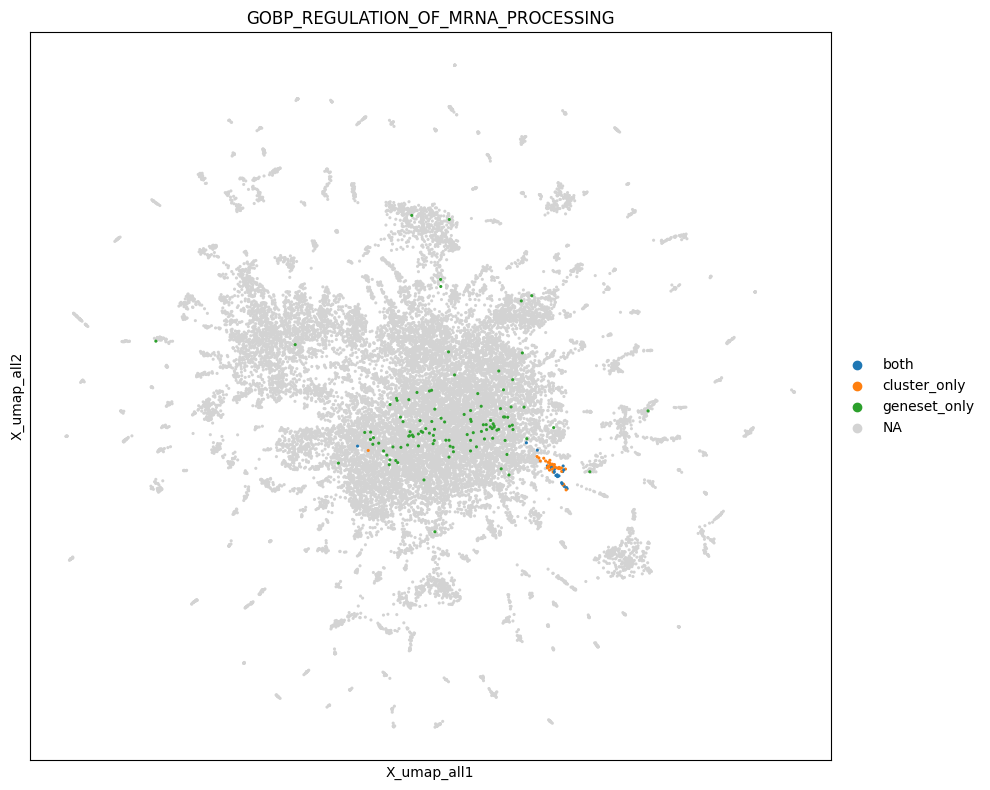

In [17]:
# Investiagte single cluster
PATHWAY="GOBP_REGULATION_OF_MRNA_PROCESSING"
p_cluster = set(adata.obs[adata.obs[CLUSTER_KEY] == CLUSTER].protein.to_list())
g_geneset = {k: v for d in genesets.values() for k, v in d.items()}[PATHWAY]
p_geneset =  set(adata.obs[adata.obs.gene.isin(g_geneset)].protein.to_list())

intersection = p_cluster.intersection(p_geneset)
only_cluster = p_cluster.difference(p_geneset)
only_geneset = p_geneset.difference(p_cluster)

# Annotate cells
adata.obs["plot"] = [
    "both" if p in intersection
    else "cluster_only" if p in only_cluster
    else "geneset_only" if p in only_geneset
    else None
    for p in adata.obs.protein.to_list()
]

fig, axes = my_embs.plot_embeddings(
    adata,
    basis=[f"X_umap_{FEATURES}"],
    color=["plot"],
    title=[PATHWAY],
    size=[20],
    #palette=[["#0000A6"]],
    ncols=1,  # 2 columns, 2 rows
    figsize=(10, 8), 
    #groups=[CLUSTER],
)
plt.show()

# Make dataset of single cluster

postive class:
- all protein from the cluster

negative class:
- 10% of all reaminign clusters
PLUS
- all proteins that share at least one motif with the proteisn of the positive class

In [18]:
p_cluster = set(adata.obs[adata.obs[CLUSTER_KEY] == CLUSTER].protein.to_list())
len(p_cluster)

61

In [19]:
# Read intepro domains 

interpro_df = pd.read_csv("/home/gdallagl/myworkdir/ESMSec/data/UniProt/uniprot_InterProt_domains.tsv", sep="\t")

import re
def extract_ids(cell, prefix):
    if pd.isna(cell):
        return []
    # Find all matches like PFxxxxx or IPRxxxxx
    ids = re.findall(rf"{prefix}\d+", cell)
    return list(set(ids))  # optional: remove duplicates

# Apply parsing
interpro_df["Pfam_list"] = interpro_df["Pfam"].apply(lambda x: extract_ids(str(x), "PF"))
interpro_df["InterPro_list"] = interpro_df["InterPro"].apply(lambda x: extract_ids(str(x), "IPR"))

interpro_df["n_Pfam"] = interpro_df["Pfam_list"].apply(len)
interpro_df["n_InterPro"] = interpro_df["InterPro_list"].apply(len)

interpro_df["all_domains"] = interpro_df.apply(lambda row: set(row['Pfam_list']) | set(row['InterPro_list']), axis=1)
interpro_df

,Entry,Length,Pfam,InterPro,Pfam_list,InterPro_list,n_Pfam,n_InterPro,all_domains
0,A0A087X1C5,515,PF00067; p450; 2.;,"IPR001128; Cyt_P450.;""IPR017972; Cyt_P450_CS.""...",[PF00067],"[IPR001128, IPR002401, IPR050182, IPR017972, I...",1,6,"{IPR050182, IPR001128, PF00067, IPR017972, IPR..."
1,A0A0B4J2F0,54,PF23670; PIGBOS1; 1.;,NaN,[PF23670],[],1,0,{PF23670}
2,A0A0C5B5G6,16,PF21945; MT-RNR1; 1.;,IPR054130; MT-RNR1.;,[PF21945],[IPR054130],1,1,"{IPR054130, PF21945}"
3,A0A0K2S4Q6,201,PF07686; V-set; 1.;,"IPR050671; CD300_family_receptors.;""IPR007110;...",[PF07686],"[IPR013783, IPR013106, IPR007110, IPR050671, I...",1,6,"{IPR013783, IPR013106, IPR007110, PF07686, IPR..."
4,A0A0U1RRE5,68,PF21949; NoBody; 1.;,IPR047852; NoBody.;,[PF21949],[IPR047852],1,1,"{IPR047852, PF21949}"
...,...,...,...,...,...,...,...,...,...
20415,Q9UI25,63,NaN,NaN,[],[],0,0,{}
20416,Q9UI54,55,NaN,NaN,[],[],0,0,{}
20417,Q9UI72,69,NaN,NaN,[],[],0,0,{}
20418,Q9Y3F1,56,PF15789; Hyr1; 1.;,IPR031573; Cell_wall_rpt.;,[PF15789],[IPR031573],1,1,"{PF15789, IPR031573}"


In [20]:
# find all domain in protein of this cluster
tmp = interpro_df[interpro_df.Entry.isin(p_cluster)].all_domains
domains_in_cluster = set()
# 3. Iterate through the Series and update the combined set
for domain_set in tmp:
    domains_in_cluster.update(domain_set)
print(domains_in_cluster)


# Find all proteins that share at least one domain with the cluster
p_sharing_domains = [row.Entry for i, row in interpro_df.iterrows() if len(row.all_domains.intersection(domains_in_cluster)) != 0]
print(f"Proteins sharing ≥1 domain: {len(p_sharing_domains)}")
# Remove the positive (target cluster) proteins
p_sharing_domains = [p for p in p_sharing_domains if p not in p_cluster]
print(f"Proteins sharing domains (excluding cluster): {len(p_sharing_domains)}")


# # OPTIONAL --> subset protein with same domains
# interpro_df_sharing = interpro_df[interpro_df.Entry.isin(p_sharing_domains)].copy()
# # Convert list of domains to a frozenset (so it's hashable) --< ifnore order
# interpro_df_sharing['domain_signature'] = interpro_df_sharing['all_domains'].apply(lambda d: frozenset(d))
# # Group by identical domain composition
# domain_groups = interpro_df_sharing.groupby('domain_signature')
# # Randomly sample up to N proteins per domain group
# subsampled_groups = []
# N=np.inf # inf to take all
# for sig, group in domain_groups:
#     if len(group) > N:
#         group_sample = group.sample(n=N, random_state=42)
#     else:
#         group_sample = group  # keep all if group smaller than N
#     subsampled_groups.append(group_sample)
# interpro_df_subsampled = pd.concat(subsampled_groups, ignore_index=True)
# print(f"Subsampled {len(interpro_df_subsampled)} proteins "
#       f"from {len(domain_groups)} domain groups (max {N} per group).")
# display(interpro_df_subsampled)
# p_sharing_domains = interpro_df_subsampled.Entry.to_list()


overlap_check = set(p_cluster).intersection(set(p_sharing_domains))
if len(overlap_check) > 0:
    print(f"⚠️ WARNING: {len(overlap_check)} positive proteins found in negatives!")
    print(f"Proteins: {overlap_check}")
else:
    print("✓ No overlap between positives and negatives")

{'IPR034897', 'PF00658', 'IPR034417', 'IPR050374', 'IPR010912', 'IPR034995', 'IPR049093', 'IPR034827', 'IPR016304', 'PF17654', 'IPR004088', 'IPR034501', 'IPR051106', 'IPR035979', 'IPR034159', 'PF00013', 'IPR040434', 'IPR049094', 'PF20809', 'IPR034506', 'IPR034134', 'IPR050502', 'IPR034492', 'IPR029000', 'PF07744', 'IPR002130', 'PF08081', 'IPR034158', 'IPR052084', 'IPR034419', 'IPR000504', 'IPR034516', 'PF00076', 'IPR034830', 'IPR034138', 'IPR034131', 'IPR034173', 'IPR034175', 'IPR020892', 'IPR034855', 'IPR047188', 'IPR001878', 'IPR029538', 'IPR034418', 'IPR034174', 'IPR034494', 'IPR034843', 'IPR051945', 'PF20810', 'IPR050907', 'IPR050666', 'IPR052285', 'IPR034486', 'PF11627', 'IPR034278', 'IPR034801', 'IPR034423', 'IPR034421', 'IPR034845', 'IPR012921', 'PF00160', 'IPR034420', 'IPR034854', 'IPR034503', 'IPR003954', 'IPR034594', 'IPR034588', 'PF00098', 'IPR045305', 'IPR002004', 'IPR034168', 'IPR047190', 'IPR012604', 'IPR034500', 'IPR004087', 'IPR045844', 'IPR051847', 'IPR034837', 'IPR034

In [21]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

def create_train_test_df(adata, target_cluster, cluster_column='leiden_pca', 
                         negative_sample_ratio=0.05, random_state=42, forced_negatives=None):
    """
    Create a balanced dataframe with train/val/test splits for binary classification.
    Samples only a small fraction from each negative cluster.
    
    Parameters
    ----------
    adata : AnnData
        Your AnnData object
    target_cluster : str or int
        The cluster to label as 1 (positive class)
    cluster_column : str
        Column name in adata.obs containing cluster assignments
    negative_sample_ratio : float, default=0.05
        Fraction of proteins to sample from each negative cluster
    random_state : int, default=42
        Random seed for reproducibility
    forced_negatives : list or None
        Optional list of protein IDs to include as additional negatives.
    
    Returns
    -------
    pd.DataFrame
        DataFrame with columns: protein, gene, label, sequence, set
    """

    # Create base dataframe
    df = pd.DataFrame({
        'protein': adata.obs['protein'].values,
        'gene': adata.obs['gene'].values,
        'sequence': adata.obs['sequence'].values,
        'cluster': adata.obs[cluster_column].values
    })

    # Remove duplicates
    df = df.drop_duplicates(subset='protein', keep='first')

    # Separate positive and negative classes
    positive_df = df[df['cluster'] == target_cluster].copy()
    negative_df = df[df['cluster'] != target_cluster].copy()

    print(f"Target cluster '{target_cluster}':")
    print(f"  Positive samples: {len(positive_df)}")
    print(f"  Total negative samples: {len(negative_df)}")

    # Initialize list for sampled negatives
    sampled_negatives = []
    unique_negative_clusters = negative_df['cluster'].unique()

    np.random.seed(random_state)

    # ✅ Add forced negatives (if any)
    if forced_negatives is not None:
        forced_neg_df = negative_df[negative_df['protein'].isin(forced_negatives)]
        sampled_negatives.append(forced_neg_df)
        print(f"Added {len(forced_neg_df)} forced negatives.")

    # ✅ Sample from each negative cluster (avoid re-sampling forced proteins)
    for neg_cluster in unique_negative_clusters:
        cluster_data = negative_df[negative_df['cluster'] == neg_cluster]

        # Remove any forced negatives before sampling
        if forced_negatives is not None:
            cluster_data = cluster_data[~cluster_data['protein'].isin(forced_negatives)]

        n_samples = max(0, int(len(cluster_data) * negative_sample_ratio))
        n_samples = min(n_samples, len(cluster_data))  # safety check

        if n_samples > 0:
            sampled = cluster_data.sample(n=n_samples, random_state=random_state)
            sampled_negatives.append(sampled)
            #print(f"  Cluster {neg_cluster}: sampled {n_samples}/{len(cluster_data)} proteins")

    # Combine negatives
    sampled_negative_df = pd.concat(sampled_negatives, ignore_index=True)
    sampled_negative_df = sampled_negative_df.drop_duplicates(subset='protein')

    print(f"\nTotal sampled negatives (unique): {len(sampled_negative_df)}")

    # Label the data
    positive_df['label'] = 1
    sampled_negative_df['label'] = 0

    df_balanced = pd.concat([positive_df, sampled_negative_df], ignore_index=True)
    df_balanced = df_balanced.drop('cluster', axis=1)

    print(f"\nBalanced dataset size: {len(df_balanced)}")
    print(f"Label distribution:\n{df_balanced['label'].value_counts()}\n")

    # ---- Simple 80/20 train-test split ----
    train_df, test_df = train_test_split(
        df_balanced,
        test_size=0.2,
        stratify=df_balanced['label'],
        random_state=random_state
    )

    # ---- Copy ONE test protein into validation ----
    if len(test_df) > 0:
        val_df = test_df.sample(n=1, random_state=random_state)
        val_prot = val_df['protein'].iloc[0]
        print(f"\nValidation protein selected: {val_prot}")
    else:
        raise ValueError("No samples available in test set for validation selection.")

    # ---- Assign set labels ----
    train_prots = set(train_df['protein'])
    test_prots = set(test_df['protein'])
    val_prots = {val_prot}

    df_balanced['set'] = df_balanced['protein'].apply(
        lambda p: (
            'val' if p in val_prots
            else 'train' if p in train_prots
            else 'test'
        )
    )

    # Reorder columns
    df_balanced = df_balanced[['protein', 'gene', 'label', 'sequence', 'set']]

    # Summary
    print("Split distribution:")
    split_dist = df_balanced.groupby('set')['label'].value_counts().unstack(fill_value=0)
    print(split_dist)
    print("\nSet sizes:")
    print(df_balanced['set'].value_counts())

    print("\nClass balance:")
    pos = (df_balanced['label'] == 1).sum()
    neg = (df_balanced['label'] == 0).sum()
    print(f"Positive samples: {pos} ({pos / len(df_balanced) * 100:.1f}%)")
    print(f"Negative samples: {neg} ({neg / len(df_balanced) * 100:.1f}%)")

    return df_balanced


df = create_train_test_df(
    adata=adata,
    target_cluster=CLUSTER,
    cluster_column=CLUSTER_KEY,
    negative_sample_ratio=1,  # Sample 10% from each negative cluster
    random_state=42,
    forced_negatives=p_sharing_domains  # list of protein IDs
)

print("\nFirst few rows:")
display(df.head(10))

# Save
path = f'/home/gdallagl/myworkdir/ESMSec/data/esm_clusters/RNA-binding_cluster_{CLUSTER}_{CLUSTER_KEY}.csv'
df.to_csv(
    path,
    index=False
)
print(path)


Target cluster '4':
  Positive samples: 61
  Total negative samples: 20344
Added 307 forced negatives.



Total sampled negatives (unique): 20344

Balanced dataset size: 20405
Label distribution:
label
0    20344
1       61
Name: count, dtype: int64


Validation protein selected: Q7LFL8
Split distribution:
label      0   1
set             
test    4068  12
train  16275  49
val        1   0

Set sizes:
set
train    16324
test      4080
val          1
Name: count, dtype: int64

Class balance:
Positive samples: 61 (0.3%)
Negative samples: 20344 (99.7%)

First few rows:


,protein,gene,label,sequence,set
0,A6NDE4,RBMY1B,1,MVEADHPGKLFIGGLNRETNEKMLKAVFGKHGPISEVLLIKDRTSK...,test
1,O00425,IGF2BP3,1,MNKLYIGNLSENAAPSDLESIFKDAKIPVSGPFLVKTGYAFVDCPD...,train
2,O75494,SRSF10,1,MSRYLRPPNTSLFVRNVADDTRSEDLRREFGRYGPIVDVYVPLDFY...,train
3,P09651,HNRNPA1,1,MSKSESPKEPEQLRKLFIGGLSFETTDESLRSHFEQWGTLTDCVVM...,test
4,P0DJD3,RBMY1A1,1,MVEADHPGKLFIGGLNRETNEKMLKAVFGKHGPISEVLLIKDRTSK...,train
5,P0DJD4,RBMY1C,1,MVEADHPGKLFIGGLNRETNEKMLKAVFGKHGPISEVLLIKDRTSK...,train
6,P11940,PABPC1,1,MNPSAPSYPMASLYVGDLHPDVTEAMLYEKFSPAGPILSIRVCRDM...,train
7,P22626,HNRNPA2B1,1,MEKTLETVPLERKKREKEQFRKLFIGGLSFETTEESLRNYYEQWGK...,train
8,P31483,TIA1,1,MEDEMPKTLYVGNLSRDVTEALILQLFSQIGPCKNCKMIMDTAGND...,train
9,P38159,RBMX,1,MVEADRPGKLFIGGLNTETNEKALEAVFGKYGRIVEVLLMKDRETN...,train


/home/gdallagl/myworkdir/ESMSec/data/esm_clusters/RNA-binding_cluster_4_leiden_all_initial_loose.csv


In [26]:
df[df.protein.duplicated()]

,protein,gene,label,sequence,set


{'Q8WXF0', 'Q9BWF3', 'A6NEQ0', 'Q14011', 'Q8N7X1', 'P11940', 'Q07955', 'P0CB38', 'O43347', 'A0A2R8Y4L2', 'Q96E39', 'P09651', 'P22626', 'P57052', 'Q16629', 'Q9BRL6', 'Q9Y3B4', 'P0DJD4', 'Q9Y580', 'Q13243', 'Q9BQ04', 'Q9NTZ6', 'Q01130', 'Q9NW13', 'O75494', 'A6NDE4', 'Q13247', 'Q96DH6', 'Q9Y6M1', 'Q96DU9', 'P51991', 'P98179', 'Q13242', 'Q15415', 'Q9Y388', 'Q01085', 'Q13310', 'Q32P51', 'Q9NX07', 'Q13151', 'Q76FK4', 'Q8IXT5', 'O00425', 'P52298', 'Q08170', 'P0DJD3', 'Q96EP5', 'P84103', 'Q9H361', 'Q9NZI8', 'Q9Y4C8', 'Q96T58', 'Q15427', 'Q9UNP9', 'Q4VXU2', 'P0C7P1', 'O75526', 'Q96PK6', 'Q5JQF8', 'P38159', 'P31483'}
{'Q6IQ49', 'Q9HC36', 'O00631', 'Q5VWM4', 'Q8N142', 'O00522', 'P04217', 'Q8NE65', 'Q6IFG1', 'Q3MII6', 'P15509', 'O15431', 'Q9Y2D2', 'Q9BU19', 'Q12980', 'Q07001', 'Q8NH41', 'P0DPQ3', 'Q8N5C6', 'Q08E93', 'Q8WYN0', 'Q8NI22', 'Q13129', 'Q9UER7', 'A6NMK7', 'Q8IYX4', 'Q96EN8', 'Q9GZM5', 'Q92753', 'Q96JN0', 'Q5JR98', 'P09914', 'Q15846', 'Q9Y5P2', 'Q8NH09', 'O75783', 'Q9UP38', 'P22301', 'Q7Z

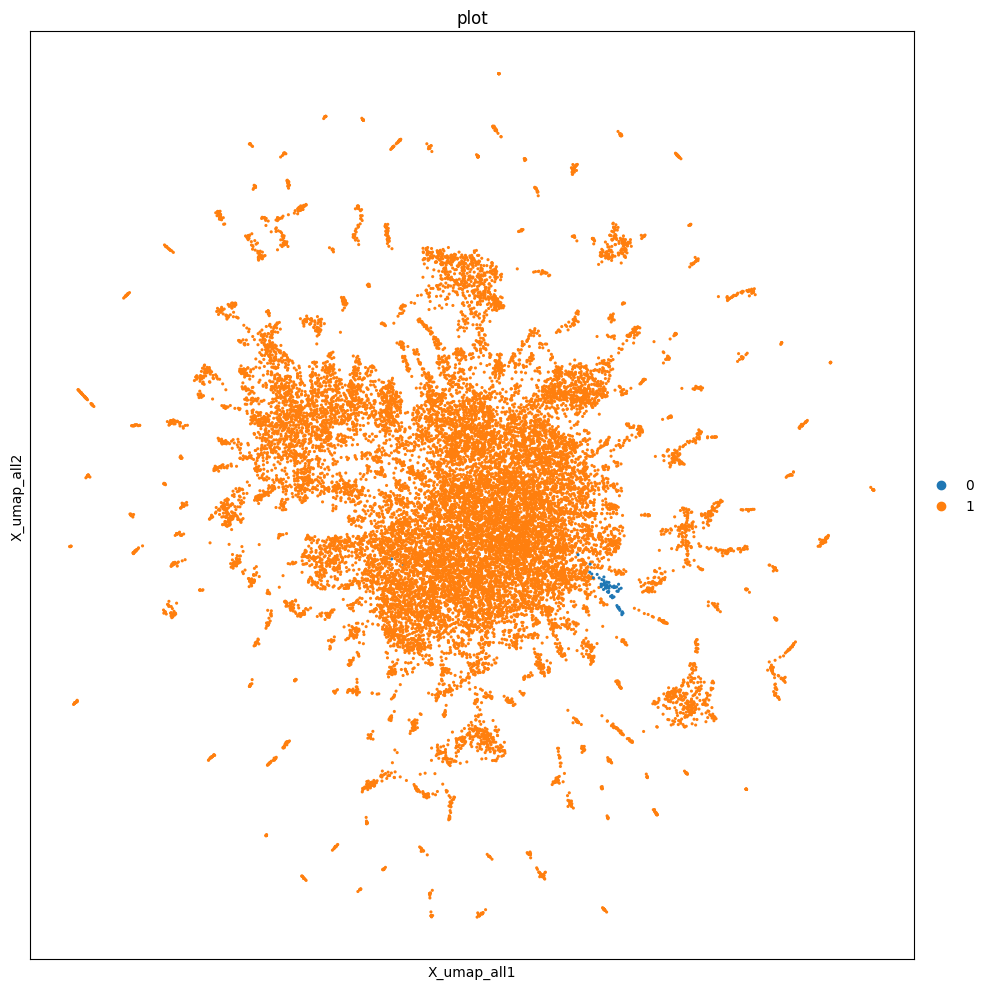

In [22]:
# Investiagte single cluster
p_pos = set(df[df.label == 1].protein.to_list())
p_neg = set(df[df.label == 0].protein.to_list())

print(p_pos)
print(p_neg)

# Annotate cells
adata.obs["plot"] = [
    "0" if p in p_pos
    else "1" if p in p_neg
    else None
    for p in adata.obs.protein.to_list()
]

fig, axes = my_embs.plot_embeddings(
    adata,
    basis=[f"X_umap_{FEATURES}"],
    color=["plot"],
    #title=["Secreted Status"],
    size=[20],
    #palette=[["#0000A6"]],
    ncols=1,  # 2 columns, 2 rows
    figsize=(10, 10), 
    #groups=[CLUSTER],
)
plt.show()

---

{'Q8WXF0', 'Q9BWF3', 'A6NEQ0', 'Q14011', 'Q8N7X1', 'P11940', 'Q07955', 'P0CB38', 'O43347', 'A0A2R8Y4L2', 'Q96E39', 'P09651', 'P22626', 'P57052', 'Q16629', 'Q9BRL6', 'Q9Y3B4', 'P0DJD4', 'Q9Y580', 'Q13243', 'Q9BQ04', 'Q9NTZ6', 'Q01130', 'Q9NW13', 'O75494', 'A6NDE4', 'Q13247', 'Q96DH6', 'Q9Y6M1', 'Q96DU9', 'P51991', 'P98179', 'Q13242', 'Q15415', 'Q9Y388', 'Q01085', 'Q13310', 'Q32P51', 'Q9NX07', 'Q13151', 'Q76FK4', 'Q8IXT5', 'O00425', 'P52298', 'Q08170', 'P0DJD3', 'Q96EP5', 'P84103', 'Q9H361', 'Q9NZI8', 'Q9Y4C8', 'Q96T58', 'Q15427', 'Q9UNP9', 'Q4VXU2', 'P0C7P1', 'O75526', 'Q96PK6', 'Q5JQF8', 'P38159', 'P31483'}
leiden_all_initial_loose
1      2
0      0
2      0
3      0
4      0
      ..
99     0
100    0
101    0
102    0
103    0
Name: count, Length: 104, dtype: int64


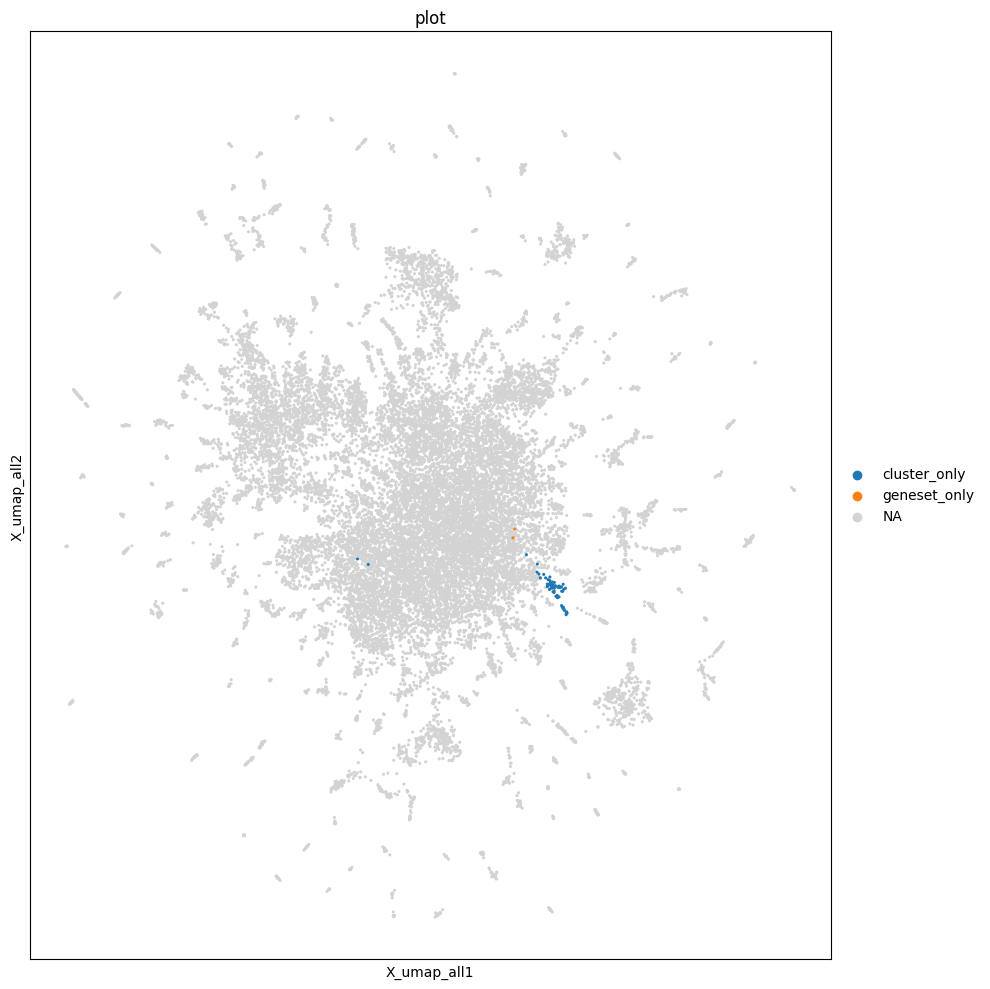

In [23]:
# Investiagte single cluster
p_cluster = set(df[df.label == 1].protein.to_list())
p_geneset =  set(['P08579', 'Q5SZQ8']

)

print(p_cluster)
print(adata.obs.loc[adata.obs.protein.isin(p_geneset), CLUSTER_KEY].value_counts())

intersection = p_cluster.intersection(p_geneset)
only_cluster = p_cluster.difference(p_geneset)
only_geneset = p_geneset.difference(p_cluster)

# Annotate cells
adata.obs["plot"] = [
    "both" if p in intersection
    else "cluster_only" if p in only_cluster
    else "geneset_only" if p in only_geneset
    else None
    for p in adata.obs.protein.to_list()
]

fig, axes = my_embs.plot_embeddings(
    adata,
    basis=[f"X_umap_{FEATURES}"],
    color=["plot"],
    #title=["Secreted Status"],
    size=[20],
    #palette=[["#0000A6"]],
    ncols=1,  # 2 columns, 2 rows
    figsize=(10, 10), 
    #groups=[CLUSTER],
)
plt.show()

In [24]:
df[df.protein == "P31483"]


,protein,gene,label,sequence,set
8,P31483,TIA1,1,MEDEMPKTLYVGNLSRDVTEALILQLFSQIGPCKNCKMIMDTAGND...,train
